## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp

/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [6]:
times, counts = getLineage("DoupeAggregate.tsv")

In [7]:
times

array([  3.,  10.,  21.,  42.,  84., 180., 365.])

In [8]:
counts

array([[ 90.,  43.,   4., ...,   0.,   0.,   0.],
       [ 96., 102.,  34., ...,   0.,   0.,   0.],
       [140.,  79.,  38., ...,   0.,   0.,   0.],
       ...,
       [ 83.,  77.,  38., ...,   0.,   0.,   0.],
       [ 40.,  59.,  43., ...,   0.,   0.,   0.],
       [ 12.,  18.,  15., ...,   0.,   0.,   1.]])

### Exploring the data

We showed that the simulations showed a linear growth in average clone size over time. Here we repeat the test on the experimental data.

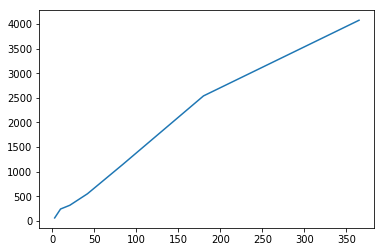

In [9]:
averageClones = [ sum([size*number for (size,number) in enumerate(t)])  for t in counts] 
plt.plot(times,averageClones)

In [10]:
from mpmath import *
import cmath

In [11]:
import math
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [12]:
def F(x, y, t, r, gamma):
#     v = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5)
    v = (1 - 4 * r)** 0.5    
#     w = (gamma * (1 - 2 * r) - 2 * r) / scipy.linalg.fractional_matrix_power(
#         2 * gamma * (1 - 4 * r), 0.5)
    w = (gamma * (1 - 2 * r) - 2 * r) / (2 * gamma * (1 - 4 * r)** 0.5)    
#     gg = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5) / gamma
    gg = (1 - 4 * r)** 0.5 / gamma
    u = (1 - y) * np.exp(-gamma * t)
    u0 = (1 - y)
    Q = 1 + 2 * w - gg * u0 + (2 * r * (x - y) + y - 1) / gamma
    C = (-Q * whitm(w, 0, gg * u0) + (1 + 2 * w) * whitm(1 + w, 0, gg * u0)) / \
        (Q * whitw(w, 0, gg * u0) + 2 * whitw(1 + w, 0, gg * u0))
    f = 1 - u + \
        (u * (1 + v) - gamma * (1 + 2 * w)) / (2 * r) + \
        (gamma / (2 * r)) * ((1 + 2 * w) * whitm(1 + w, 0, u * gg) -
                             2 * C * whitw(1 + w, 0, u * gg)) / \
        (whitm(w, 0, u * gg) + C * whitw(w, 0, u * gg))
    return f


def Antal(z, t, r, gamma):
    g = []
    for k in range(len(z)):
        if z[k] == 1:
            g.append(1)
        else:
            g.append(F(z[k], z[k], t, r, gamma))
            
#     for k in range(1, len(z) + 1):
#         if z[k] == 1:
#             g[k] = 1
#         else:
#             g[k] = F(z[k], z[k], t, r, gamma)

    return g

In [13]:
def Psurv(t, l, r, rho):
    rho = rho - 0.00001
    gamma = rho / (1 - rho)
    T = l * t
    p = 1 - np.real(Antal([0], T, r, gamma))
#     if (p <= 0 or p > 1 or np.isnan(p)):
    if (p <= 0 or p > 1):
        p = Psurv(t, l, r + 0.00001, rho - 0.001)
    return p

In [14]:
def Pn(n, t, l, r, rho, N, returnConsecutive='', max_n=''):
    if max(n) >= N:
        N = max(n) + 1
    rho = rho - 0.00001
    assert (rho < 1)
    assert (rho > 0)
    gamma = rho / (1 - rho)
    T = l * t
#     k = range(N)
#     Gvals = Antal(cmath.exp(2 * np.pi * 1j * k / N), T, r, gamma)
    Gvals = Antal([cmath.exp(2 * np.pi * 1j * k / N) for k in range(int(N))], T, r, gamma)
    p = []

    if returnConsecutive:
        p = np.zeros(max_n)
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#              p[n[lp]] = \
#                 np.real((1 / N) *
#                         sum(Gvals * np.exp(-2 * np.pi * 1j * k * n[lp] / N)))
            temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[n[lp]-1] = np.real((1 / N) *sum([a*b for a,b in zip(Gvals,temporary)]))
                               
    else:
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#             p[lp] = \
#                 np.real((1 / N) * sum(Gvals *
#                                       np.exp(-2 * np.pi * 1j * k * n[lp] / N)))          
            Temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[lp] = np.real((1 / N) * sum(a*b for a,b in zip(Gvals,Temporary)))
#     print(Gvals)
    tst = sum(p)
#     print(tst)
    if (tst > 1 or tst < 0 or np.isnan(tst)):
        print('Pathological point: r=' + str(r) + ' rho=' + str(
            rho) + '. Making 0.1% perturbation')
        p = Pn(n, t, l, r + 0.00001, rho - 0.001, N, returnConsecutive, max_n)

#     for x in range(len(p)):
#         if (p[x] < 0):
#             p[x] = 0

#     p[p < 0 & p > -1e-5] = 0

    return(p)

In [19]:
def logLikelihood(obs,lpBins,binSize):
    maxClone = len(lpBins)
    def noisyMul(a,b,i):
        #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
        print("logP",a, "\nobsv", b)
        return(a[i]*b[i])
    obsBins = [sum(obs[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))]
    return(sum([obsBins[j]*lpBins[j] for j in range(maxClone)]))

def logProbability(probability,binSize):
    binSizeList = [sum(probability[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))]
    logFreq = [0 if n<=0 else math.log10(n) for n in binSizeList]
    return(logFreq)

def calculateLikelihood(probability,binSize,data):
    lpBins = logProbability(probability, binSize)
    like = logLikelihood(data,lpBins,binSize)
    #print(like)
    return(like)

In [16]:
def main(t,nRange,rRange,binSize,data):
    maxN = max(list(map(max, nRange)))
#     lambda
    L1 = 2.9
    timePoints = range(len(t))
    PScanPP = [[np.zeros(len(rRange)) for L2 in range(len(rhoRange))] for L4 in timePoints]
#     PSurvScanPP = [np.zeros(len(nRange)) for L3 in range(len(rRange))]
    nBadValues = 0
         
    for L4 in timePoints:
        for L2 in range(len(rhoRange)):
            for L3 in range(len(rRange)):
                probS = Psurv(t[L4], L1, rRange[L3], rhoRange[L2])
                avgN = 1 / probS
                Niter = max([normal_round(int(4*avgN)), normal_round(1.5*max(nRange[L4])), 10])
                probN = Pn(nRange[L4], t[L4], L1, rRange[L3], rhoRange[L2], Niter, 'returnConsecutive', maxN)
            
                if any(probN > 1) or \
                        sum(probN) > 1 or \
                        probS > 1 or \
                        probS <0 or \
                        abs(probS-sum(probN))>1e-3:
                    print('Bad values at time t=' + str(t[L4]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
                    print('any(probN>1=' + str(any(probN>1)) + ', sum(probN)>1=' + str(sum(probN)>1) + ', (probS-sum(probN))=' + str(probS-sum(probN)))
                    nBadValues += 1
                else:
                    print('Completed time t=' + str(t[L4]) + ' weeks, rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
#                 PSurvScanPP_local[L3][L4] = probS
#                 PScanPP_local[L3][L4][:] = probN
                
                sizeProb = probN/probS
                PScanPP[L4][L2][L3] = calculateLikelihood(sizeProb,binSize,data[L4])
    return(PScanPP) 

In [17]:
nSize = len(np.transpose(counts))
nBin = int(round(np.log(nSize)/np.log(2)+0.5))
binSize = np.append([1],[2**(n-1) for n in range(1,(nBin+1))])


In [20]:
# example:t = [10 / 7, 30 / 7, 84 / 7, 26]
t = times/7
# example: nRange = [list(range(1, 8)),list(range(1, 14)),list(range(1, 27)),list(range(1, 56))]
# For Doupe data, the maximum clone size is(4,6,11,28,29,90,175)
nRange = [list(range(1,4)),list(range(1,6)),list(range(1,11)),list(range(1,28)),list(range(1,29)),list(range(1,90)),list(range(1,175))]
bins=20
rhoRange = [(i*0.8/bins) for i in range(1,bins)]
rRange = [(i*0.1/bins) for i in range(1, bins)]
%time result = main(t,nRange,rRange,binSize,counts)

Bad values at time t=0.42857142857142855 rho=0.04 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12294395227931854')]
Bad values at time t=0.42857142857142855 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12293359161851614')]
Bad values at time t=0.42857142857142855 rho=0.04 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12292614172292193')]
Bad values at time t=0.42857142857142855 rho=0.04 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.1229215990806265')]
Bad values at time t=0.42857142857142855 rho=0.04 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12291996019258022')]
Bad values at time t=0.42857142857142855 rho=0.04 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12292122157279406')]
Bad values at time t=0.42857142857142855 rho=0.04 r=0.035
any(probN>1=False, sum(probN)>1=False, (probS

Bad values at time t=0.42857142857142855 rho=0.12000000000000002 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11141709698136026')]
Bad values at time t=0.42857142857142855 rho=0.16 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10116297211464764')]
Bad values at time t=0.42857142857142855 rho=0.16 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10138885915217577')]
Bad values at time t=0.42857142857142855 rho=0.16 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10161528970462286')]
Bad values at time t=0.42857142857142855 rho=0.16 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10184225590410956')]
Bad values at time t=0.42857142857142855 rho=0.16 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10206974999032681')]
Bad values at time t=0.42857142857142855 rho=0.16 r=0.030000000000000006
any(probN>1=False, sum(probN)

Bad values at time t=0.42857142857142855 rho=0.24000000000000005 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.091956335589825633')]
Bad values at time t=0.42857142857142855 rho=0.24000000000000005 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.092322933581017175')]
Bad values at time t=0.42857142857142855 rho=0.24000000000000005 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.09268819427152164')]
Bad values at time t=0.42857142857142855 rho=0.28 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.078137931098024582')]
Bad values at time t=0.42857142857142855 rho=0.28 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.078605923260977151')]
Bad values at time t=0.42857142857142855 rho=0.28 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.079071575316019382')]
Bad values at time t=0.42857142857142855 rho=0.28 r=0.02
any(probN>

Bad values at time t=0.42857142857142855 rho=0.36 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.071918443664453213')]
Bad values at time t=0.42857142857142855 rho=0.36 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.072471611953572435')]
Bad values at time t=0.42857142857142855 rho=0.36 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.073020934574931196')]
Bad values at time t=0.42857142857142855 rho=0.4 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054799238160723851')]
Bad values at time t=0.42857142857142855 rho=0.4 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.055483526686362694')]
Bad values at time t=0.42857142857142855 rho=0.4 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.05616275872535359')]
Bad values at time t=0.42857142857142855 rho=0.4 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[

Bad values at time t=0.42857142857142855 rho=0.4800000000000001 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.050376333101583071')]
Bad values at time t=0.42857142857142855 rho=0.4800000000000001 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.051082468741559639')]
Bad values at time t=0.42857142857142855 rho=0.4800000000000001 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.051783203384918597')]
Bad values at time t=0.42857142857142855 rho=0.4800000000000001 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052478578002810639')]
Bad values at time t=0.42857142857142855 rho=0.4800000000000001 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.053168633183785285')]
Bad values at time t=0.42857142857142855 rho=0.52 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032920301505645622')]
Bad values at time t=0.42857142857142855 rho=0.52 r=0.01

Bad values at time t=0.42857142857142855 rho=0.6 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.031485792901181364')]
Bad values at time t=0.42857142857142855 rho=0.6 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032240584883533208')]
Bad values at time t=0.42857142857142855 rho=0.6 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03299110053058929')]
Bad values at time t=0.42857142857142855 rho=0.6 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033737344563879001')]
Bad values at time t=0.42857142857142855 rho=0.6 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03447932215235705')]
Bad values at time t=0.42857142857142855 rho=0.64 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015228071458128545')]
Bad values at time t=0.42857142857142855 rho=0.64 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0160068594

Bad values at time t=0.42857142857142855 rho=0.72 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016235503123341322')]
Bad values at time t=0.42857142857142855 rho=0.72 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016894085882623866')]
Bad values at time t=0.42857142857142855 rho=0.72 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017553475336857471')]
Bad values at time t=0.42857142857142855 rho=0.72 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018213540174347176')]
Bad values at time t=0.42857142857142855 rho=0.72 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018874152804997602')]
Bad values at time t=0.42857142857142855 rho=0.76 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044483825081530481')]
Bad values at time t=0.42857142857142855 rho=0.76 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00

Bad values at time t=1.4285714285714286 rho=0.08 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.2492878332619316')]
Bad values at time t=1.4285714285714286 rho=0.08 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.24819303378806001')]
Bad values at time t=1.4285714285714286 rho=0.08 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.2471166505362683')]
Bad values at time t=1.4285714285714286 rho=0.08 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.24605755828116305')]
Bad values at time t=1.4285714285714286 rho=0.08 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.24501469968985023')]
Bad values at time t=1.4285714285714286 rho=0.08 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.24398708153204329')]
Bad values at time t=1.4285714285714286 rho=0.12000000000000002 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.212

Bad values at time t=1.4285714285714286 rho=0.2 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.14968710196488799')]
Bad values at time t=1.4285714285714286 rho=0.2 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.15132565740397008')]
Bad values at time t=1.4285714285714286 rho=0.2 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.15285995254583296')]
Bad values at time t=1.4285714285714286 rho=0.2 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.15429534546772516')]
Bad values at time t=1.4285714285714286 rho=0.2 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.15563689720723928')]
Bad values at time t=1.4285714285714286 rho=0.2 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.15688939039512539')]
Bad values at time t=1.4285714285714286 rho=0.2 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.158057346

Bad values at time t=1.4285714285714286 rho=0.32 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.075161101501896477')]
Bad values at time t=1.4285714285714286 rho=0.32 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.078040441051960507')]
Bad values at time t=1.4285714285714286 rho=0.32 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.080792070095177748')]
Bad values at time t=1.4285714285714286 rho=0.32 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.083421209329420876')]
Bad values at time t=1.4285714285714286 rho=0.32 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.085932875867589464')]
Bad values at time t=1.4285714285714286 rho=0.32 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.088331888616760335')]
Bad values at time t=1.4285714285714286 rho=0.32 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-su

Bad values at time t=1.4285714285714286 rho=0.44000000000000006 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037947258335576328')]
Bad values at time t=1.4285714285714286 rho=0.44000000000000006 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040348251271016933')]
Bad values at time t=1.4285714285714286 rho=0.44000000000000006 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.042692910291410868')]
Bad values at time t=1.4285714285714286 rho=0.44000000000000006 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.044980535537062161')]
Bad values at time t=1.4285714285714286 rho=0.44000000000000006 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047210676528529172')]
Bad values at time t=1.4285714285714286 rho=0.44000000000000006 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.049383104051137439')]
Bad values at 

Bad values at time t=1.4285714285714286 rho=0.56 r=0.045
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013902097288240212')]
Bad values at time t=1.4285714285714286 rho=0.56 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015504821322287032')]
Bad values at time t=1.4285714285714286 rho=0.56 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017123836766593681')]
Bad values at time t=1.4285714285714286 rho=0.56 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018754132341525453')]
Bad values at time t=1.4285714285714286 rho=0.56 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020391117393497082')]
Bad values at time t=1.4285714285714286 rho=0.56 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022030597929574958')]
Bad values at time t=1.4285714285714286 rho=0.56 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-s

Bad values at time t=1.4285714285714286 rho=0.68 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0070678565366307788')]
Bad values at time t=1.4285714285714286 rho=0.68 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080115526138747617')]
Bad values at time t=1.4285714285714286 rho=0.68 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0089907785157675724')]
Bad values at time t=1.4285714285714286 rho=0.68 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010001813864299769')]
Bad values at time t=1.4285714285714286 rho=0.68 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011041056985596653')]
Bad values at time t=1.4285714285714286 rho=0.68 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012105039094412295')]
Bad values at time t=1.4285714285714286 rho=0.68 r=0.085
any(probN>1=False, sum(probN)>1=False, (prob

Bad values at time t=3.0 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.17337081757004236')]
Bad values at time t=3.0 rho=0.04 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.17196504908339971')]
Bad values at time t=3.0 rho=0.04 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.17054424149585512')]
Bad values at time t=3.0 rho=0.04 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.16911190791571629')]
Bad values at time t=3.0 rho=0.08 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.097490196658774453')]
Bad values at time t=3.0 rho=0.08 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10428287665987213')]
Bad values at time t=3.0 rho=0.08 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11010066917782679')]
Bad values at time t=3.0 rho=0.08 r=0.02
any(probN>1=False, sum(probN)>1=False, (pro

Bad values at time t=3.0 rho=0.16 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.087962979863035362')]
Bad values at time t=3.0 rho=0.2 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0097143043793755934')]
Bad values at time t=3.0 rho=0.2 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015501815718419465')]
Bad values at time t=3.0 rho=0.2 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020963199439528291')]
Bad values at time t=3.0 rho=0.2 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026090164363418156')]
Bad values at time t=3.0 rho=0.2 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030882945858031197')]
Bad values at time t=3.0 rho=0.2 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03534777830217295')]
Bad values at time t=3.0 rho=0.2 r=0.035
any(probN>1=False, sum(prob

Bad values at time t=3.0 rho=0.32 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0053896466998800685')]
Bad values at time t=3.0 rho=0.32 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0072379468385791457')]
Bad values at time t=3.0 rho=0.32 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0091961323135340001')]
Bad values at time t=3.0 rho=0.32 r=0.035
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011227107403612657')]
Bad values at time t=3.0 rho=0.32 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013299606312233814')]
Bad values at time t=3.0 rho=0.32 r=0.045
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015387586564857059')]
Bad values at time t=3.0 rho=0.32 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01746961254115309')]
Bad values at time t=3.0 rho=0.32 r=0.05500000000000001
any(probN>1=False, s

Bad values at time t=3.0 rho=0.44000000000000006 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0090403576666370222')]
Bad values at time t=3.0 rho=0.44000000000000006 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010195843950318584')]
Bad values at time t=3.0 rho=0.44000000000000006 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011366863231382363')]
Bad values at time t=3.0 rho=0.44000000000000006 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012545463026784498')]
Bad values at time t=3.0 rho=0.44000000000000006 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013724581471051489')]
Bad values at time t=3.0 rho=0.44000000000000006 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014898016585914386')]
Bad values at time t=3.0 rho=0.44000000000000006 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016060380

Bad values at time t=3.0 rho=0.6 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032934554204772093')]
Bad values at time t=3.0 rho=0.6 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0038261270769516242')]
Bad values at time t=3.0 rho=0.6 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0043886125177458046')]
Bad values at time t=3.0 rho=0.6 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049773333355296323')]
Bad values at time t=3.0 rho=0.6 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055887020905953655')]
Completed time t=3.0 weeks, rho=0.64 r=0.005
Completed time t=3.0 weeks, rho=0.64 r=0.01
Completed time t=3.0 weeks, rho=0.64 r=0.015000000000000003
Completed time t=3.0 weeks, rho=0.64 r=0.02
Completed time t=3.0 weeks, rho=0.64 r=0.025
Completed time t=3.0 weeks, rho=0.64 r=0.030000000000000006
Completed time t=3.0 weeks, rho=0.64 r=0.035
Completed

Bad values at time t=6.0 rho=0.04 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.089423216486852475')]
Bad values at time t=6.0 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.090533656929749129')]
Bad values at time t=6.0 rho=0.04 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.091382688185913663')]
Bad values at time t=6.0 rho=0.04 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.092005338143028026')]
Bad values at time t=6.0 rho=0.04 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.092432002156099369')]
Bad values at time t=6.0 rho=0.08 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021323758669838933')]
Bad values at time t=6.0 rho=0.08 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058208685475672484')]
Bad values at time t=6.0 rho=0.08 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=Fa

Completed time t=6.0 weeks, rho=0.2 r=0.01
Completed time t=6.0 weeks, rho=0.2 r=0.015000000000000003
Completed time t=6.0 weeks, rho=0.2 r=0.02
Bad values at time t=6.0 rho=0.2 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010265752415554719')]
Bad values at time t=6.0 rho=0.2 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0016900621345455891')]
Bad values at time t=6.0 rho=0.2 r=0.035
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025258981738268682')]
Bad values at time t=6.0 rho=0.2 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035171273816334558')]
Bad values at time t=6.0 rho=0.2 r=0.045
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0046409499055638515')]
Bad values at time t=6.0 rho=0.2 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058718987299472003')]
Bad values at time t=6.0 rho=0.2 r=0.05500000000000001
any(pro

Completed time t=6.0 weeks, rho=0.36 r=0.030000000000000006
Completed time t=6.0 weeks, rho=0.36 r=0.035
Completed time t=6.0 weeks, rho=0.36 r=0.04
Completed time t=6.0 weeks, rho=0.36 r=0.045
Completed time t=6.0 weeks, rho=0.36 r=0.05
Completed time t=6.0 weeks, rho=0.36 r=0.05500000000000001
Completed time t=6.0 weeks, rho=0.36 r=0.06000000000000001
Completed time t=6.0 weeks, rho=0.36 r=0.065
Bad values at time t=6.0 rho=0.36 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012737681415705415')]
Bad values at time t=6.0 rho=0.36 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015972337066604836')]
Bad values at time t=6.0 rho=0.36 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019565689730467462')]
Bad values at time t=6.0 rho=0.36 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023488747796204801')]
Bad values at time t=6.0 rho=0.36 r=0.09
any(probN>1=False, sum(probN)>1=Fals

Completed time t=6.0 weeks, rho=0.64 r=0.065
Completed time t=6.0 weeks, rho=0.64 r=0.07
Completed time t=6.0 weeks, rho=0.64 r=0.075
Completed time t=6.0 weeks, rho=0.64 r=0.08
Completed time t=6.0 weeks, rho=0.64 r=0.085
Completed time t=6.0 weeks, rho=0.64 r=0.09
Completed time t=6.0 weeks, rho=0.64 r=0.095
Completed time t=6.0 weeks, rho=0.68 r=0.005
Completed time t=6.0 weeks, rho=0.68 r=0.01
Completed time t=6.0 weeks, rho=0.68 r=0.015000000000000003
Completed time t=6.0 weeks, rho=0.68 r=0.02
Completed time t=6.0 weeks, rho=0.68 r=0.025
Completed time t=6.0 weeks, rho=0.68 r=0.030000000000000006
Completed time t=6.0 weeks, rho=0.68 r=0.035
Completed time t=6.0 weeks, rho=0.68 r=0.04
Completed time t=6.0 weeks, rho=0.68 r=0.045
Completed time t=6.0 weeks, rho=0.68 r=0.05
Completed time t=6.0 weeks, rho=0.68 r=0.05500000000000001
Completed time t=6.0 weeks, rho=0.68 r=0.06000000000000001
Completed time t=6.0 weeks, rho=0.68 r=0.065
Completed time t=6.0 weeks, rho=0.68 r=0.07
Compl

Bad values at time t=12.0 rho=0.12000000000000002 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0098163784054909886')]
Bad values at time t=12.0 rho=0.12000000000000002 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018140417843661716')]
Bad values at time t=12.0 rho=0.12000000000000002 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026261079308542268')]
Bad values at time t=12.0 rho=0.12000000000000002 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033420406317149376')]
Bad values at time t=12.0 rho=0.12000000000000002 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03938184639636777')]
Bad values at time t=12.0 rho=0.12000000000000002 r=0.035
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.044165332965237503')]
Bad values at time t=12.0 rho=0.12000000000000002 r=0.04
any(probN>1=False, sum(probN)>1=False, 

Bad values at time t=12.0 rho=0.24000000000000005 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010091704713162841')]
Bad values at time t=12.0 rho=0.24000000000000005 r=0.045
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012335679499830998')]
Bad values at time t=12.0 rho=0.24000000000000005 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014477800842692512')]
Bad values at time t=12.0 rho=0.24000000000000005 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016472240393259174')]
Bad values at time t=12.0 rho=0.24000000000000005 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018293856769236561')]
Bad values at time t=12.0 rho=0.24000000000000005 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019932467397660858')]
Bad values at time t=12.0 rho=0.24000000000000005 r=0.07
any(probN>1=False, sum(probN)>1=False, (p

Completed time t=12.0 weeks, rho=0.4 r=0.015000000000000003
Completed time t=12.0 weeks, rho=0.4 r=0.02
Completed time t=12.0 weeks, rho=0.4 r=0.025
Completed time t=12.0 weeks, rho=0.4 r=0.030000000000000006
Completed time t=12.0 weeks, rho=0.4 r=0.035
Bad values at time t=12.0 rho=0.4 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011983556371453208')]
Bad values at time t=12.0 rho=0.4 r=0.045
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017723991614168044')]
Bad values at time t=12.0 rho=0.4 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024456741702238438')]
Bad values at time t=12.0 rho=0.4 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031977980277917428')]
Bad values at time t=12.0 rho=0.4 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040069240089102287')]
Bad values at time t=12.0 rho=0.4 r=0.065
any(probN>1=False, sum(

Bad values at time t=12.0 rho=0.56 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014243528820693796')]
Bad values at time t=12.0 rho=0.56 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017846655812550072')]
Bad values at time t=12.0 rho=0.56 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021748045313882969')]
Bad values at time t=12.0 rho=0.56 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025886881433549447')]
Bad values at time t=12.0 rho=0.56 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030202863998895491')]
Bad values at time t=12.0 rho=0.56 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0034638664541667696')]
Completed time t=12.0 weeks, rho=0.6 r=0.005
Completed time t=12.0 weeks, rho=0.6 r=0.01
Completed time t=12.0 weeks, rho=0.6 r=0.015000000000000003
Completed time t=12.0 weeks, rho=0.6 r=0.02
Completed time t=1

Bad values at time t=25.714285714285715 rho=0.04 r=0.065
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.048296465559242829')]
Bad values at time t=25.714285714285715 rho=0.04 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047178598643497827')]
Bad values at time t=25.714285714285715 rho=0.04 r=0.075
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046020754858046242')]
Bad values at time t=25.714285714285715 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.044850621440249538')]
Bad values at time t=25.714285714285715 rho=0.04 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.04368700747237797')]
Bad values at time t=25.714285714285715 rho=0.04 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.042542543480745487')]
Bad values at time t=25.714285714285715 rho=0.04 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.04142554264

Bad values at time t=25.714285714285715 rho=0.16 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010840857491638184')]
Bad values at time t=25.714285714285715 rho=0.16 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011416839260645045')]
Bad values at time t=25.714285714285715 rho=0.16 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011911412064776')]
Bad values at time t=25.714285714285715 rho=0.16 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01233168140690355')]
Completed time t=25.714285714285715 weeks, rho=0.2 r=0.005
Completed time t=25.714285714285715 weeks, rho=0.2 r=0.01
Completed time t=25.714285714285715 weeks, rho=0.2 r=0.015000000000000003
Completed time t=25.714285714285715 weeks, rho=0.2 r=0.02
Completed time t=25.714285714285715 weeks, rho=0.2 r=0.025
Completed time t=25.714285714285715 weeks, rho=0.2 r=0.030000000000000006
Completed time t=25.714285714285715 weeks, r

Bad values at time t=25.714285714285715 rho=0.32 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002111462995113611')]
Bad values at time t=25.714285714285715 rho=0.32 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024114996476941875')]
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.005
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.01
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.015000000000000003
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.02
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.025
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.030000000000000006
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.035
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.04
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.045
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.05
Completed time t=25.714285714285715 weeks, rho=0.36 r=0.05500000000000001
Completed 

Completed time t=25.714285714285715 weeks, rho=0.56 r=0.095
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.005
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.01
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.015000000000000003
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.02
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.025
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.030000000000000006
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.035
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.04
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.045
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.05
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.05500000000000001
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.06000000000000001
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.065
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.07
Completed time t=25.714285714285715 weeks, rho=0.6 r=0.075
Co

Bad values at time t=52.142857142857146 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0221332971023952')]
Bad values at time t=52.142857142857146 rho=0.04 r=0.085
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021396395267717305')]
Bad values at time t=52.142857142857146 rho=0.04 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020692707001963684')]
Bad values at time t=52.142857142857146 rho=0.04 r=0.095
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020022854087088204')]
Completed time t=52.142857142857146 weeks, rho=0.08 r=0.005
Completed time t=52.142857142857146 weeks, rho=0.08 r=0.01
Bad values at time t=52.142857142857146 rho=0.08 r=0.015000000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014778895726031971')]
Bad values at time t=52.142857142857146 rho=0.08 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035572186724150412')]

Completed time t=52.142857142857146 weeks, rho=0.2 r=0.005
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.01
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.015000000000000003
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.02
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.025
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.030000000000000006
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.035
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.04
Completed time t=52.142857142857146 weeks, rho=0.2 r=0.045
Bad values at time t=52.142857142857146 rho=0.2 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013255980593485511')]
Bad values at time t=52.142857142857146 rho=0.2 r=0.05500000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017275153702937945')]
Bad values at time t=52.142857142857146 rho=0.2 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002

Completed time t=52.142857142857146 weeks, rho=0.36 r=0.09
Completed time t=52.142857142857146 weeks, rho=0.36 r=0.095
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.005
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.01
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.015000000000000003
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.02
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.025
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.030000000000000006
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.035
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.04
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.045
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.05
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.05500000000000001
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.06000000000000001
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.065
Completed time t=52.142857142857146 weeks, rho=0.4 r=0.07
Co

Completed time t=52.142857142857146 weeks, rho=0.64 r=0.04
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.045
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.05
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.05500000000000001
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.06000000000000001
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.065
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.07
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.075
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.08
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.085
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.09
Completed time t=52.142857142857146 weeks, rho=0.64 r=0.095
Completed time t=52.142857142857146 weeks, rho=0.68 r=0.005
Completed time t=52.142857142857146 weeks, rho=0.68 r=0.01
Completed time t=52.142857142857146 weeks, rho=0.68 r=0.015000000000000003
Completed time t=52.142857142857146 weeks, rho=0.68 r=0.02
Comp

In [21]:

pickle_out = open("pickled_grid_search","wb")
pickle.dump(result, pickle_out)
pickle_out.close()

In [6]:
pickle_in = open("pickled_grid_search_analytical","rb")
data = pickle.load(pickle_in)

In [7]:
np.shape(data)

(7, 19, 19)

In [22]:
result

[[array([-70.96214349, -70.91690786, -70.87188168, -70.82706541,
         -70.78245953, -70.73806451, -70.69388087, -70.64990913,
         -70.60614983, -70.56260352, -70.5192708 , -70.47615224,
         -70.43324847, -70.39056012, -70.34808784, -70.30583231,
         -70.26379423, -70.2219743 , -70.18037329]),
  array([-69.62889036, -69.57986771, -69.53105591, -69.48245519,
         -69.43406579, -69.38588798, -69.33792203, -69.29016824,
         -69.24262692, -69.19529838, -69.14818295, -69.10128099,
         -69.05459287, -69.00811896, -68.96185967, -68.9158154 ,
         -68.8699866 , -68.82437369, -68.77897716]),
  array([-68.25333353, -68.20268476, -68.1522584 , -68.10205434,
         -68.05207253, -68.0023129 , -67.95277541, -67.90346002,
         -67.85436672, -67.80549549, -67.75684634, -67.7084193 ,
         -67.66021438, -67.61223164, -67.56447114, -67.51693294,
         -67.46961714, -67.42252383, -67.37565313]),
  array([-66.83615268, -66.78611989, -66.73632435, -66.686765

In [8]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0,0.1,0,0.8],aspect=0.125)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    x = np.linspace(0,0.1,50)
    y = x/0.12
    plt.plot(x, y, '-c')
    plt.colorbar()
    plt.show()

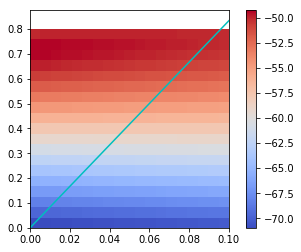

In [9]:
plotLikelihood(result[0])

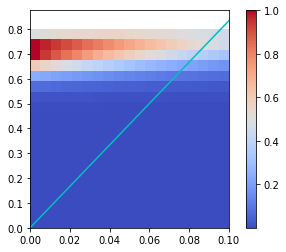

In [54]:
T =result[0]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

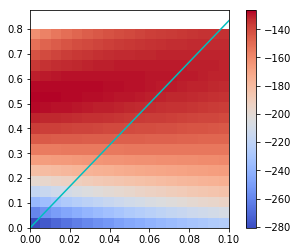

In [55]:
plotLikelihood(result[1])

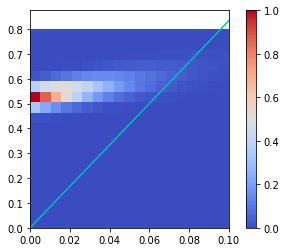

In [57]:
T =result[1]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

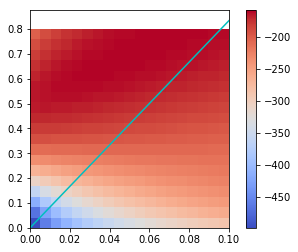

In [58]:
plotLikelihood(result[2])

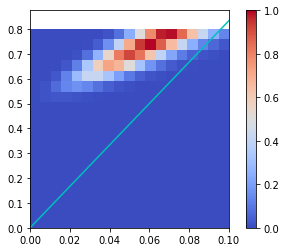

In [59]:
T =result[2]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

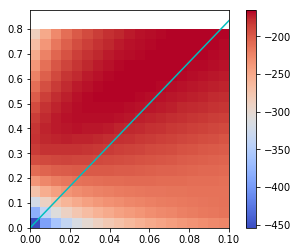

In [60]:
plotLikelihood(result[3])

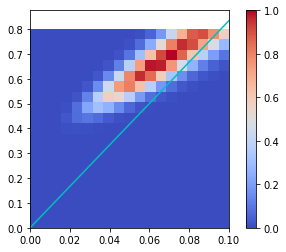

In [61]:
T =result[3]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

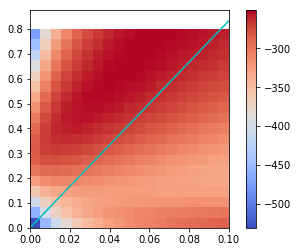

In [62]:
plotLikelihood(result[4])

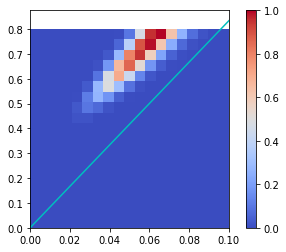

In [63]:
T =result[4]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

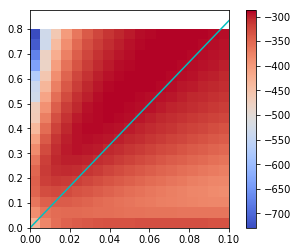

In [64]:
plotLikelihood(result[5])

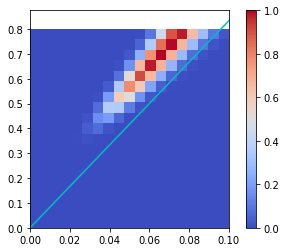

In [65]:
T =result[5]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

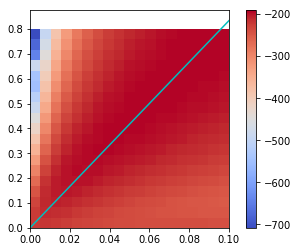

In [66]:
plotLikelihood(result[6])

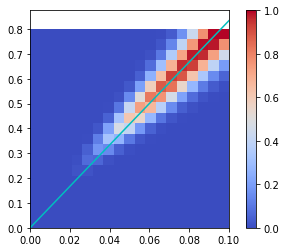

In [67]:
T =result[6]
rScaled = T - max([max(i) for i in T])
rNormalised = np.exp(rScaled)
plotLikelihood(rNormalised)

In [39]:
[np.where(r == max(r)) for r in result]

[(array([39]),),
 (array([31]),),
 (array([41]),),
 (array([31]),),
 (array([41]),),
 (array([30]),),
 (array([20]),)]

In [ ]:
rDistribution = np.cumsum(rNormalised)
print(np.where(rDistribution>0.025))
print(np.where(rDistribution<0.975))

In [23]:
rVal = [(i*0.1/bins) for i in range(1,bins)]
rVal[334:378]

[0.067,
 0.06720000000000001,
 0.0674,
 0.06760000000000001,
 0.0678,
 0.068,
 0.0682,
 0.0684,
 0.06860000000000001,
 0.0688,
 0.069,
 0.0692,
 0.0694,
 0.06960000000000001,
 0.0698,
 0.07,
 0.0702,
 0.0704,
 0.07060000000000001,
 0.0708,
 0.071,
 0.0712,
 0.0714,
 0.07160000000000001,
 0.0718,
 0.072,
 0.0722,
 0.0724,
 0.07260000000000001,
 0.0728,
 0.073,
 0.0732,
 0.0734,
 0.07360000000000001,
 0.07379999999999999,
 0.074,
 0.0742,
 0.07440000000000001,
 0.07460000000000001,
 0.07479999999999999,
 0.075,
 0.0752,
 0.07540000000000001,
 0.07560000000000001]

In [24]:
print(0.067/0.12)
print(0.076/0.12)

0.5583333333333333
0.6333333333333333
